## Setup

In [50]:
import os
pwd = os.path.abspath('.')
os.chdir(os.path.join(pwd, '../src/'))

In [51]:
from collections import Counter
import pandas as pd
import seaborn as sns
from core.environment import EnvironmentSettings
from string import Template
import matplotlib.pyplot as plt

import datetime

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysis

In [83]:
from datareader.data_reader import NseDerivatiesReader
reader = NseDerivatiesReader()

from datareader.data_reader import MultiDatesDataReader, DateRangeDataReader
multidates_reader = MultiDatesDataReader(reader)
daterange_reader = DateRangeDataReader(reader)

from core.core import MarketDaysHelper

In [54]:
yest = datetime.date.today() + datetime.timedelta(days=-1)

#### Calculations

In [55]:
from dataprocess.data_processor import CalculationWorker
from core.core import Instrumentation
from core.column_definition import BaseColumns

In [264]:
class DerivativesCalculatedColumns:
  CloseToPrevCloseChangePerc: str = 'CloseToPrevCloseChangePerc'
  OpenToPrevCloseChangePerc: str = 'OpenToPrevCloseChangePerc'
  PreviousCloseAmount: str = 'PreviousCloseAmount'
  OpenAmount: str = 'OpenAmount'
  CloseAmount: str = 'CloseAmount'
  HighAmount: str = 'HighAmount'
  LowAmount: str = 'LowAmount'
  AmountDiffOpenToPrevClose: str = 'AmountDiffOpenToPrevClose'
  AmountDiffCloseToPrevClose: str = 'AmountDiffCloseToPrevClose'
  AmountDiffOpenToPrevClose: str = 'AmountDiffOpenToPrevClose'
  ClosestStrike: str = 'ClosestStrike'
  LotSize: str = 'LotSize'

class DerivativesBaseColumns(BaseColumns):
  AveragePrice: str = 'AvrgPric'
  OptionType: str = 'OptionType'
  ExpiryDate: str = 'ExpiryDate'
  StrikePrice: str = 'StrkPric'
  Turnover: str = 'Turnover (Rs. Cr.)'
  OpenInterest: str = 'OpenInterest'


In [225]:
class DerivativesPriceCalculationWorker (CalculationWorker):
  @Instrumentation.trace(name="DerivativesPriceCalculationWorker")
  def add_calculated_columns(self, data):
    data[DerivativesCalculatedColumns.CloseToPrevCloseChangePerc] = (data[DerivativesBaseColumns.Close] / data[DerivativesBaseColumns.PreviousClose] - 1) * 100
    data[DerivativesCalculatedColumns.OpenToPrevCloseChangePerc] = (data[DerivativesBaseColumns.Open] / data[DerivativesBaseColumns.PreviousClose] - 1) * 100
    
    data[DerivativesCalculatedColumns.PreviousCloseAmount] = data[DerivativesBaseColumns.PreviousClose] * data[DerivativesCalculatedColumns.LotSize]
    data[DerivativesCalculatedColumns.OpenAmount] = data[DerivativesBaseColumns.Open] * data[DerivativesCalculatedColumns.LotSize]
    data[DerivativesCalculatedColumns.CloseAmount] = data[DerivativesBaseColumns.Close] * data[DerivativesCalculatedColumns.LotSize]
    data[DerivativesCalculatedColumns.HighAmount] = data[DerivativesBaseColumns.High] * data[DerivativesCalculatedColumns.LotSize]
    data[DerivativesCalculatedColumns.LowAmount] = data[DerivativesBaseColumns.Low] * data[DerivativesCalculatedColumns.LotSize]

    data[DerivativesCalculatedColumns.AmountDiffOpenToPrevClose] = data[DerivativesCalculatedColumns.OpenAmount] - data[DerivativesCalculatedColumns.PreviousCloseAmount]
    data[DerivativesCalculatedColumns.AmountDiffCloseToPrevClose] = data[DerivativesCalculatedColumns.CloseAmount] - data[DerivativesCalculatedColumns.PreviousCloseAmount]
    

In [226]:
class DerivativesLotSizeCalculationWorker (CalculationWorker):
  @Instrumentation.trace(name="DerivativesLotSizeCalculationWorker")
  def add_calculated_columns(self, data):
    lotsize_data = pd.read_csv("../manual_data/nse_fo_lotsize.csv")
    cur_expiry_col = lotsize_data.columns[2]
    data = pd.merge(
        data,
        lotsize_data[['SYMBOL', cur_expiry_col]],
        how="left",
        left_on=DerivativesBaseColumns.Identifier,
        right_on='SYMBOL'
    )
    data.rename(columns={cur_expiry_col: DerivativesCalculatedColumns.LotSize}, inplace=True)
    return data

In [227]:
from dataprocess.data_processor import CalculationPipeline
derivatives_calc_pipeline = CalculationPipeline()
derivatives_calc_pipeline.add_calculation_worker(DerivativesLotSizeCalculationWorker())
derivatives_calc_pipeline.add_calculation_worker(DerivativesPriceCalculationWorker())

#### Expiry Analysis

In [64]:
expiries = MarketDaysHelper.get_monthly_expiry_dates(6)
pre_expiries = [MarketDaysHelper.get_previous_market_day(x) for x in expiries]
data = multidates_reader.read(expiries)

In [65]:
data = derivatives_calc_pipeline.run(data)

DerivativesLotSizeCalculationWorker took 0 seconds
DerivativesPriceCalculationWorker took 0 seconds


In [67]:
preferred_options = data
preferred_options = preferred_options[preferred_options[DerivativesBaseColumns.Date].dt.strftime('%d-%b-%Y') == preferred_options[DerivativesBaseColumns.ExpiryDate]]
preferred_options = preferred_options[(preferred_options[DerivativesBaseColumns.PreviousClose] >= 0.5) & (preferred_options[DerivativesBaseColumns.PreviousClose] <= 1.5)]

preferred_options.loc[preferred_options[preferred_options[DerivativesBaseColumns.OptionType] == 'CE'].groupby([DerivativesBaseColumns.ExpiryDate, DerivativesBaseColumns.Identifier])['StrkPric'].idxmin(), DerivativesCalculatedColumns.ClosestStrike] = True
preferred_options.loc[preferred_options[preferred_options[DerivativesBaseColumns.OptionType] == 'PE'].groupby([DerivativesBaseColumns.ExpiryDate, DerivativesBaseColumns.Identifier])['StrkPric'].idxmax(), DerivativesCalculatedColumns.ClosestStrike] = True

preferred_options = preferred_options[preferred_options[DerivativesCalculatedColumns.ClosestStrike] == True]
#data['Date'].dt.strftime('%d-%b-%Y').str.upper()

In [68]:
quantile = preferred_options.sort_values(by=DerivativesCalculatedColumns.OpenToPrevCloseChangePerc, ascending=True)[DerivativesCalculatedColumns.OpenToPrevCloseChangePerc].quantile(q=0.8)
best_n_percentile = preferred_options[preferred_options[DerivativesCalculatedColumns.OpenToPrevCloseChangePerc] >= quantile]

In [278]:
preferred_options.to_csv("../output/preferred_options.csv")
best_n_percentile.to_csv("../output/best_n_percentile.csv")

In [70]:
target_data = preferred_options

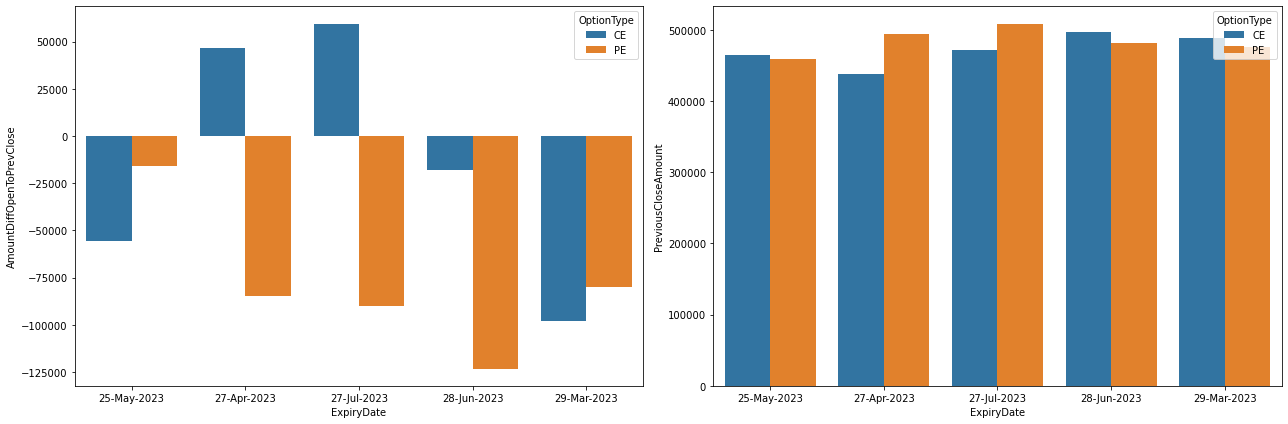

In [71]:
#fig, ax = plt.subplots(figsize=(18, 6))
plt.rcParams["figure.figsize"] = [18, 6]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)
sns.barplot(
  data=target_data.groupby([DerivativesBaseColumns.ExpiryDate, DerivativesBaseColumns.OptionType])[DerivativesCalculatedColumns.AmountDiffOpenToPrevClose].sum().reset_index(), 
  x=DerivativesBaseColumns.ExpiryDate,
  hue=DerivativesBaseColumns.OptionType,
  y=DerivativesCalculatedColumns.AmountDiffOpenToPrevClose,
  ax=axes[0]
)
sns.barplot(
  data=target_data.groupby([DerivativesBaseColumns.ExpiryDate, DerivativesBaseColumns.OptionType])[DerivativesCalculatedColumns.PreviousCloseAmount].sum().reset_index(), 
  x=DerivativesBaseColumns.ExpiryDate,
  hue=DerivativesBaseColumns.OptionType,
  y=DerivativesCalculatedColumns.PreviousCloseAmount,
  ax=axes[1]
)
plt.show()

In [72]:
target_data.groupby([DerivativesBaseColumns.Identifier])[DerivativesCalculatedColumns.OpenToPrevCloseChangePerc].count()\
  .sort_values(ascending=False).reset_index().to_csv("../output/count_by_id.csv")

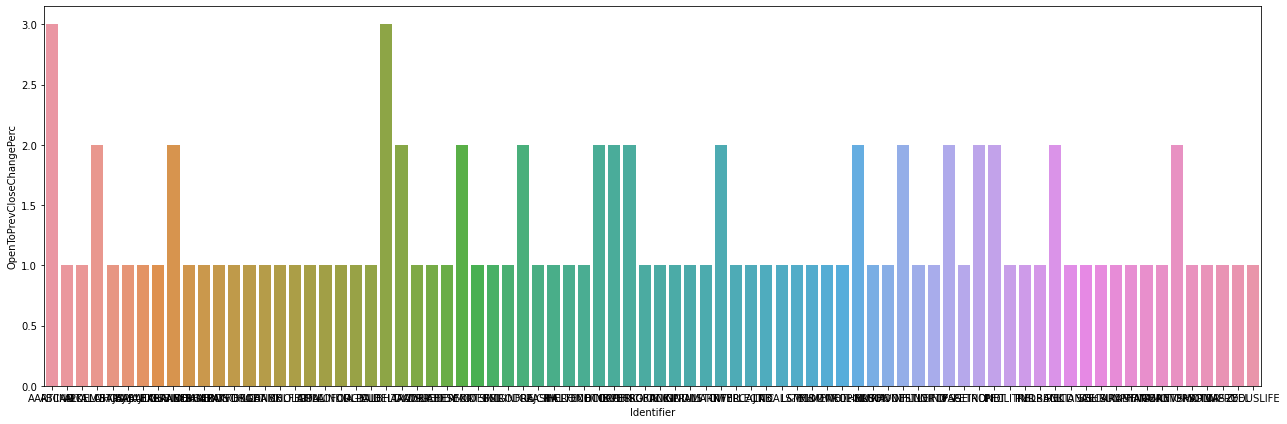

In [73]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(
    data=target_data.sort_values(DerivativesCalculatedColumns.OpenToPrevCloseChangePerc, ascending=False)\
      .head(100).groupby([DerivativesBaseColumns.Identifier])[DerivativesCalculatedColumns.OpenToPrevCloseChangePerc].count().reset_index(), 
    x='Identifier',
    y='OpenToPrevCloseChangePerc'
  )
plt.show()

#### Overbought / Oversold Stocks

##### Load Data

In [335]:
overbought_stocks = pd.read_csv("../output/rsi-crossed-above.csv")
oversold_stocks = pd.read_csv("../output/rsi-crossed-below.csv")
holding_days = 10
budget_min = 8000
budget_max = 12000
min_lots_oi = 50

In [229]:
from_date = pd.to_datetime(overbought_stocks[DerivativesBaseColumns.Date].min())
to_date = pd.to_datetime(overbought_stocks[DerivativesBaseColumns.Date].max()) + datetime.timedelta(days=holding_days)

In [230]:
data = daterange_reader.read(from_date, to_date)

No columns to parse from file date(2023, 04, 18),
https://archives.nseindia.com/content/fo/NSE_FO_bhavcopy_24042023.csv
https://archives.nseindia.com/content/fo/NSE_FO_bhavcopy_25042023.csv
https://archives.nseindia.com/content/fo/NSE_FO_bhavcopy_05062023.csv
https://archives.nseindia.com/content/fo/NSE_FO_bhavcopy_02082023.csv
https://archives.nseindia.com/content/fo/NSE_FO_bhavcopy_03082023.csv
The read operation timed out date(2023, 08, 03),
https://archives.nseindia.com/content/fo/NSE_FO_bhavcopy_04082023.csv
The read operation timed out date(2023, 08, 04),


In [232]:
data = derivatives_calc_pipeline.run(data)

DerivativesLotSizeCalculationWorker took 4 seconds
DerivativesPriceCalculationWorker took 0 seconds


##### Functions

In [312]:
def get_entry_option(symbol, date, option_type, entry_amount_col, budget_min, budget_max, hold_till_date, min_lots_oi, index):
    entry_option = data[
        (data[DerivativesBaseColumns.Identifier] == symbol)
        & (data[DerivativesBaseColumns.OptionType] == option_type)
        & (data[DerivativesBaseColumns.Date] == date)
        & (data[entry_amount_col].between(budget_min, budget_max))
        & (pd.to_datetime(data[DerivativesBaseColumns.ExpiryDate]) >= hold_till_date)
        & (data[DerivativesBaseColumns.OpenInterest] >= (data[DerivativesCalculatedColumns.LotSize] * min_lots_oi))
    ].sort_values(DerivativesBaseColumns.StrikePrice, ascending=False).head(1)

    if len(entry_option) > 0:
        strike_price = entry_option[DerivativesBaseColumns.StrikePrice].values[0]
        expiry_date = entry_option[DerivativesBaseColumns.ExpiryDate].values[0]
        buy_amount = entry_option[entry_amount_col].values[0]
        lotsize = entry_option[DerivativesCalculatedColumns.LotSize].values[0]

        buy = pd.DataFrame({
                    DerivativesBaseColumns.Identifier: symbol,
                    DerivativesBaseColumns.StrikePrice: strike_price,
                    DerivativesBaseColumns.ExpiryDate: expiry_date,
                    DerivativesBaseColumns.OptionType: option_type,
                    DerivativesBaseColumns.Date: pd.to_datetime(date),
                    'Credit': -1 * buy_amount,
                    'Quantity': 1 * lotsize,
                    'Type': 'Buy'
                }, index=[(index*2)])
        return buy
    else:
        return []

In [333]:
def get_exit_option(symbol, expiry_date, date, strike_price, option_type, exit_amount_profit_col, exit_amount_loss_col, 
                    buy_amount, hold_till_date, min_lots_oi, lotsize, index):
  exit_options = data[
      (data[DerivativesBaseColumns.Identifier] == symbol)
      & (data[DerivativesBaseColumns.ExpiryDate] == expiry_date)
      & (data[DerivativesBaseColumns.StrikePrice] == strike_price)
      & (data[DerivativesBaseColumns.OptionType] == option_type)
      & (data[DerivativesBaseColumns.Date].between(date + datetime.timedelta(days=1), hold_till_date))
      & (data[DerivativesBaseColumns.OpenInterest] >= (data[DerivativesCalculatedColumns.LotSize] * min_lots_oi))
  ]
  if len(exit_options) > 0:
      exit_option = exit_options[(
          (exit_options[exit_amount_profit_col] >= (buy_amount*2))
          |
          (exit_options[exit_amount_loss_col] <= (buy_amount*0.5))
        )]
      
      if len(exit_option) <= 0:
          exit_option = exit_options.sort_values(DerivativesBaseColumns.Date, ascending=False)[0:1]
          
      high_amount = exit_option[exit_amount_profit_col].values[0]
      low_amount = exit_option[exit_amount_loss_col].values[0]
      
      sell_amount = 0
      if (high_amount >= (buy_amount*2)):
          sell_amount = high_amount
      else:
          sell_amount = low_amount

      sell = pd.DataFrame({
          DerivativesBaseColumns.Identifier: symbol,
          DerivativesBaseColumns.StrikePrice: strike_price,
          DerivativesBaseColumns.ExpiryDate: expiry_date,
          DerivativesBaseColumns.OptionType: option_type,
          DerivativesBaseColumns.Date: pd.to_datetime(exit_option[DerivativesBaseColumns.Date].values[0]),
          'Credit': sell_amount,
          'Quantity': -1 * lotsize,
          'Type': 'Sell'
      }, index=[(index*2)+1])
      return sell
  else:
      return []

In [373]:
def get_trades(option_type, stocks, budget_min, budget_max, holding_days,
        entry_amount_col, exit_amount_profit_col, exit_amount_loss_col, min_lots_oi):
    
    trades = pd.DataFrame()
    non_tradables = pd.DataFrame()
    
    today = pd.to_datetime(datetime.date.today())
    stocks[DerivativesBaseColumns.Date] = pd.to_datetime(stocks[DerivativesBaseColumns.Date])
    stocks[stocks[DerivativesBaseColumns.Date] + datetime.timedelta(days=holding_days) < today]

    for index, stock in stocks.iterrows():
        symbol = stock[BaseColumns.Identifier]
        date = pd.to_datetime(stock[BaseColumns.Date])
        hold_till_date = pd.to_datetime(stock[BaseColumns.Date]) + datetime.timedelta(days=holding_days)
        buy = get_entry_option(symbol, date, option_type, entry_amount_col, budget_min, budget_max, hold_till_date, min_lots_oi, index)
        
        if len(buy) > 0:
            strike_price = buy[DerivativesBaseColumns.StrikePrice].values[0]
            expiry_date = buy[DerivativesBaseColumns.ExpiryDate].values[0]
            buy_amount = abs(buy['Credit'].values[0])
            lotsize = buy['Quantity'].values[0]

            sell = get_exit_option(symbol, expiry_date, date, strike_price, option_type, exit_amount_profit_col, exit_amount_loss_col, 
                        buy_amount, hold_till_date, min_lots_oi, lotsize, index)
            
            if len(sell) > 0:
                trades = pd.concat([trades, buy, sell], ignore_index=True)
            else:
                non_tradables = pd.concat([non_tradables, pd.DataFrame({DerivativesBaseColumns.Identifier: symbol, DerivativesBaseColumns.Date: pd.to_datetime(date), 'reason': 'No Exit'}, index=[(index*2)])])
        else:
            non_tradables = pd.concat([non_tradables, pd.DataFrame({DerivativesBaseColumns.Identifier: symbol, DerivativesBaseColumns.Date: pd.to_datetime(date), 'reason': 'No Entry'}, index=[(index*2)+1])])
    
    trades['CumCredit'] = trades['Credit'].cumsum()
    return trades, non_tradables

##### Get Trades

In [367]:
trades_pe, non_tradables_pe = get_trades('PE', overbought_stocks, budget_min, budget_max, holding_days, 
  DerivativesCalculatedColumns.CloseAmount, DerivativesCalculatedColumns.HighAmount, DerivativesCalculatedColumns.LowAmount, min_lots_oi)

In [374]:
trades_ce, non_tradables_ce = get_trades('CE', oversold_stocks, budget_min, budget_max, holding_days, 
  DerivativesCalculatedColumns.CloseAmount, DerivativesCalculatedColumns.HighAmount, DerivativesCalculatedColumns.LowAmount, min_lots_oi)

In [368]:
#trades.groupby('Identifier')['Credit'].sum()
def display_outcome(trades):
    trades = trades.sort_values('Date').reset_index()
    tot_credit = trades['Credit'].sum()
    credit_req = trades['CumCredit'].min() * -1
    print(f'Total trades: {len(trades)}, Final Balance: {round(tot_credit)}, Investment Required: {round(credit_req)}, ROI: {round(tot_credit/credit_req * 100)}%')
    display(trades.groupby(DerivativesBaseColumns.Identifier)['Credit'].sum().sort_values())

def show_losing_trades(trades):
    return trades[
        ((trades['Credit'] + trades['Credit'].shift(1)) < 0)
        &
        (trades[DerivativesBaseColumns.Identifier] == trades[DerivativesBaseColumns.Identifier].shift(1))
        &
        (trades[DerivativesBaseColumns.ExpiryDate] == trades[DerivativesBaseColumns.ExpiryDate].shift(1))
        &
        (trades[DerivativesBaseColumns.StrikePrice] == trades[DerivativesBaseColumns.StrikePrice].shift(1))
        &
        (trades[DerivativesBaseColumns.OptionType] == trades[DerivativesBaseColumns.OptionType].shift(1))
    ]

In [375]:
#display_outcome(trades_pe)
show_losing_trades(trades_pe)

,Identifier,StrkPric,ExpiryDate,OptionType,Date,Credit,Quantity,Type,CumCredit
13,TATAMOTORS,435.0,23-Feb-2023,PE,2023-02-10,6483.75,-1425.0,Sell,75783.75
15,POLYCAB,2850.0,23-Feb-2023,PE,2023-02-10,5430.00,-300.0,Sell,71673.75
17,CHOLAFIN,730.0,23-Feb-2023,PE,2023-02-07,4562.50,-1250.0,Sell,65111.25
19,COFORGE,4250.0,23-Feb-2023,PE,2023-02-10,8617.50,-150.0,Sell,62786.25
23,INFY,1600.0,23-Feb-2023,PE,2023-02-13,8520.00,-400.0,Sell,75731.25
...,...,...,...,...,...,...,...,...,...
963,PFC,215.0,31-Aug-2023,PE,2023-07-27,4030.00,-6200.0,Sell,829332.60
965,ICICIBANK,980.0,31-Aug-2023,PE,2023-08-02,9800.00,-700.0,Sell,827687.60
967,ONGC,165.0,31-Aug-2023,PE,2023-07-31,3272.50,-3850.0,Sell,822105.10
971,INDUSTOWER,165.0,31-Aug-2023,PE,2023-08-02,8500.00,-3400.0,Sell,819725.10


In [391]:
datetime.date(2023, 7, 27) + datetime.timedelta(7)

datetime.date(2023, 8, 3)

In [439]:
data_test = pd.DataFrame(data)

In [442]:
data_test[DerivativesBaseColumns.Identifier]

0          0             HAVELLS\n1           ZYDUSLIFE\n...
1          0             HAVELLS\n1           ZYDUSLIFE\n...
2          0             HAVELLS\n1           ZYDUSLIFE\n...
3          0             HAVELLS\n1           ZYDUSLIFE\n...
4          0             HAVELLS\n1           ZYDUSLIFE\n...
                                 ...                        
6430850    0             HAVELLS\n1           ZYDUSLIFE\n...
6430851    0             HAVELLS\n1           ZYDUSLIFE\n...
6430852    0             HAVELLS\n1           ZYDUSLIFE\n...
6430853    0             HAVELLS\n1           ZYDUSLIFE\n...
6430854    0             HAVELLS\n1           ZYDUSLIFE\n...
Name: Identifier, Length: 6430855, dtype: object

In [431]:
data_test[DerivativesBaseColumns.Identifier] = str(data_test[DerivativesBaseColumns.Identifier])
data_test[DerivativesBaseColumns.OptionType] = str(data_test[DerivativesBaseColumns.OptionType])
data_test[DerivativesBaseColumns.ExpiryDate] = pd.to_datetime(data_test[DerivativesBaseColumns.ExpiryDate])
data_test[DerivativesBaseColumns.Date] = pd.to_datetime(data_test[DerivativesBaseColumns.Date])

In [438]:
data_range = [pd.to_datetime(datetime.date.today() - datetime.timedelta(days=7)), pd.to_datetime(datetime.date.today())]
data_test[
    (data_test[DerivativesBaseColumns.Identifier] == 'TATAMOTORS')
    & (data_test[DerivativesBaseColumns.OptionType] == 'PE')
    & (data_test[DerivativesBaseColumns.ExpiryDate] == '31-Aug-2023')
    & (data_test[DerivativesBaseColumns.StrikePrice] == 600)
    & (data_test[DerivativesBaseColumns.Date].between(data_range[0], data_range[1]))
]

,FinInstrmNm,Identifier,ExpiryDate,StrkPric,OptionType,PreviousClose,Open,High,Low,Close,...,LotSize,CloseToPrevCloseChangePerc,OpenToPrevCloseChangePerc,PreviousCloseAmount,OpenAmount,CloseAmount,HighAmount,LowAmount,AmountDiffOpenToPrevClose,AmountDiffCloseToPrevClose


In [409]:
data_test = data_test.reset_index(drop=True)
data_test.set_index([DerivativesBaseColumns.Identifier, DerivativesBaseColumns.OptionType, DerivativesBaseColumns.ExpiryDate, DerivativesBaseColumns.Date, DerivativesBaseColumns.StrikePrice], drop=False, inplace=True)

In [418]:
mi = pd.MultiIndex.from_frame(data_test, 
                              names=[DerivativesBaseColumns.Identifier, DerivativesBaseColumns.OptionType, DerivativesBaseColumns.ExpiryDate, DerivativesBaseColumns.StrikePrice, DerivativesBaseColumns.Date])

ValueError: Length of names must match number of levels in MultiIndex.

In [339]:
display_outcome(trades_ce)

Total trades: 898, Final Balance: 1408458, Investment Required: 119018, ROI: 1183%


Identifier
PAGEIND      -23838.00
M&MFIN       -20200.00
TATACONSUM   -17685.00
ESCORTS      -16458.75
INFY         -16340.00
                ...   
IDEA          52000.00
PFC           59210.00
INDUSTOWER    70210.00
RECLTD        72400.00
AUBANK        78200.00
Name: Credit, Length: 164, dtype: float64

In [341]:
non_tradables_pe.groupby('reason').count()

,Identifier,Date,reason
9,INDIAMART,2023-01-25,No Entry
15,COFORGE,2023-01-30,No Entry
17,HCLTECH,2023-01-30,No Entry
19,MFSL,2023-01-31,No Entry
41,OBEROIRLTY,2023-02-16,No Entry


In [384]:
data[
        (data[DerivativesBaseColumns.Identifier] == 'TATAMOTORS')
        & (data[DerivativesBaseColumns.OptionType] == 'PE')
        & (data[DerivativesBaseColumns.StrikePrice] == 610)
        & (data[DerivativesBaseColumns.ExpiryDate] == '31-Aug-2023')
    ][[DerivativesBaseColumns.Date, DerivativesBaseColumns.StrikePrice, 
       DerivativesCalculatedColumns.CloseAmount, DerivativesBaseColumns.OpenInterest, DerivativesCalculatedColumns.LotSize]]

,Date,StrkPric,CloseAmount,OpenInterest,LotSize
4299397,2023-06-06,610.0,144566.25,0.0,1425.0
4345390,2023-06-07,610.0,144566.25,0.0,1425.0
4383953,2023-06-08,610.0,144566.25,0.0,1425.0
4449566,2023-06-09,610.0,144566.25,0.0,1425.0
4501627,2023-06-12,610.0,144566.25,0.0,1425.0
4547051,2023-06-13,610.0,144566.25,0.0,1425.0
4617586,2023-06-14,610.0,144566.25,0.0,1425.0
4670163,2023-06-15,610.0,144566.25,0.0,1425.0
4672618,2023-06-16,610.0,144566.25,0.0,1425.0
4748114,2023-06-19,610.0,144566.25,0.0,1425.0
